## RetinaFace (2019)

Paper: https://arxiv.org/abs/1905.00641

GitHub: https://github.com/biubug6/Pytorch_Retinaface

In [13]:
import cv2
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from Pytorch_Retinaface.models.retinaface import RetinaFace
from Pytorch_Retinaface.data import cfg_mnet, cfg_re50
from Pytorch_Retinaface.test_widerface import load_model
from Pytorch_Retinaface.layers.functions.prior_box import PriorBox
from Pytorch_Retinaface.utils.box_utils import decode, decode_landm
from Pytorch_Retinaface.utils.nms.py_cpu_nms import py_cpu_nms

In [2]:
def read_frame_as_size(video_path, size=(128, 128)):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    capture.release()
    return frame

def read_frame(video_path):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    capture.release()
    return frame


def read_all_frames(video_path):
    capture = cv2.VideoCapture(str(video_path))
    all_frames = []
    ret = True
    while True:
        ret, frame = capture.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            all_frames.append(frame)
        else:
            break
    
    capture.release()
    return all_frames


In [3]:
cfg = cfg_re50
net = RetinaFace(cfg=cfg, phase = 'test')

In [4]:
# Download weights from Google Drive. See repo for details: https://github.com/biubug6/Pytorch_Retinaface
net = load_model(net, 'Pytorch_Retinaface/weights/Resnet50_Final.pth', load_to_cpu=False)

Loading pretrained model from Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


In [5]:
net = net.eval()
net = net.cuda()

In [6]:
data = Path('../data')

# Two easy faces to ensure that we can get facial recognition working
easy1 = data/'dfdc_train_part_2/abmjszfycr_REAL.mp4'
easy2 = data/'dfdc_train_part_11/aqyvunegbf_REAL.mp4'

In [7]:
frame1 = read_frame(easy1)
frame2 = read_frame(easy2)

In [8]:
def get_detections_from_frame(frame):
    """
    Get the detections for a single frame
    """
    img = np.float32(frame)
    target_size = 1600
    max_size = 2150
    im_shape = img.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])
    resize = float(target_size) / float(im_size_min)
    
    if np.round(resize * im_size_max) > max_size:
        resize = float(max_size) / float(im_size_max)

    if resize != 1:
        img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
        
    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.cuda()
    scale = scale.cuda()
            
    loc, conf, landms = net(img)  # forward pass
    
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.cuda()
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2]])
    scale1 = scale1.cuda()
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()
    
    # ignore low scores
    DEFAULT_CONFIDENCE_THRESH = 0.02
    inds = np.where(scores > DEFAULT_CONFIDENCE_THRESH)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1]
    # order = scores.argsort()[::-1][:args.top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]
    
    # do NMS
    DEFAULT_NMS_THRESH = 0.4
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, DEFAULT_NMS_THRESH)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    # dets = dets[:args.keep_top_k, :]
    # landms = landms[:args.keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    
   
    return dets
    

In [10]:
detections1 = get_detections_from_frame(frame1)
detections2 = get_detections_from_frame(frame2)

In [11]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        
        xmin = detections[i, 0]
        ymin = detections[i, 1]
        xmax = detections[i, 2]
        ymax = detections[i, 3]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        
    plt.show()

Found 1 faces


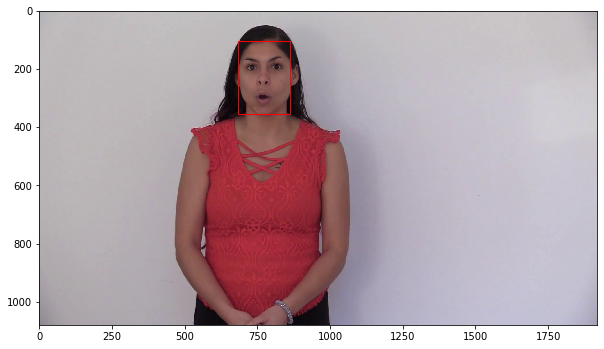

In [14]:
plot_detections(frame1, detections1, with_keypoints=False)

Found 1 faces


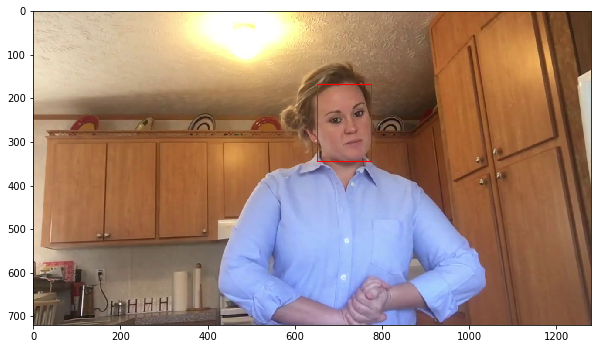

In [15]:
plot_detections(frame2, detections2, with_keypoints=False)

## Get all faces in all frames


In [16]:
def show_faces(faces, rows, columns, figsize=(20, 20)):
    
    axes = plt.subplots(rows, columns, figsize=figsize)[1]
    
    for row in range(rows):
        rowOffset = row * columns
        
        for column in range(columns):
            if rowOffset + column < len(faces):
                face = faces[rowOffset + column]
                axes[row,column].imshow(face)

In [17]:
def get_cropped_faces(frame, detections):
    
    faces = []
    
    for detection in detections:
       
        xmin = max(0, int(detection[0])) # Don't try to crop less than 0
        ymin = max(0, int(detection[1])) # Don't try to crop less than 0
        xmax = min(frame.shape[1], int(detection[2]))
        ymax = min(frame.shape[0], int(detection[3]))
        
        face = frame[ymin:ymax, xmin:xmax]
        
        faces.append(face)
    
    return faces

In [21]:
def predict_all_frames(frames):
    
    predictions = []
    for frame in tqdm_notebook(frames):
        detections = get_detections_from_frame(frame)
        
        faces = get_cropped_faces(frame, detections)
        
        if len(faces) > 0:
            predictions.extend(faces)
            
    return predictions

In [22]:
all_frames1 = read_all_frames(easy1)
all_frames2 = read_all_frames(easy2)

In [23]:
all_faces1 = predict_all_frames(all_frames1)
all_faces2 = predict_all_frames(all_frames2)

/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


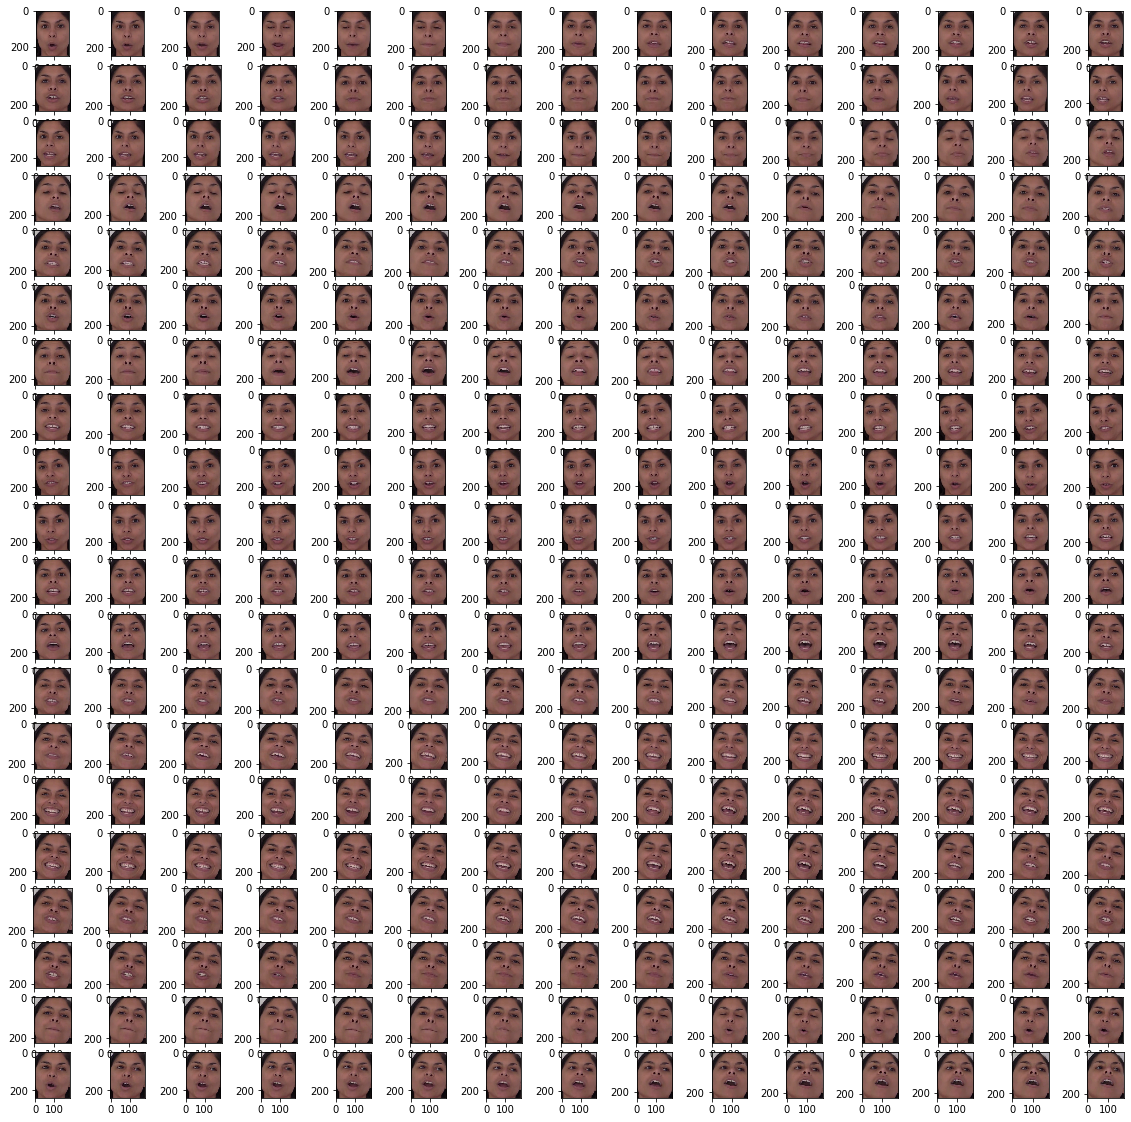

In [24]:
show_faces(all_faces1, 20, 15)

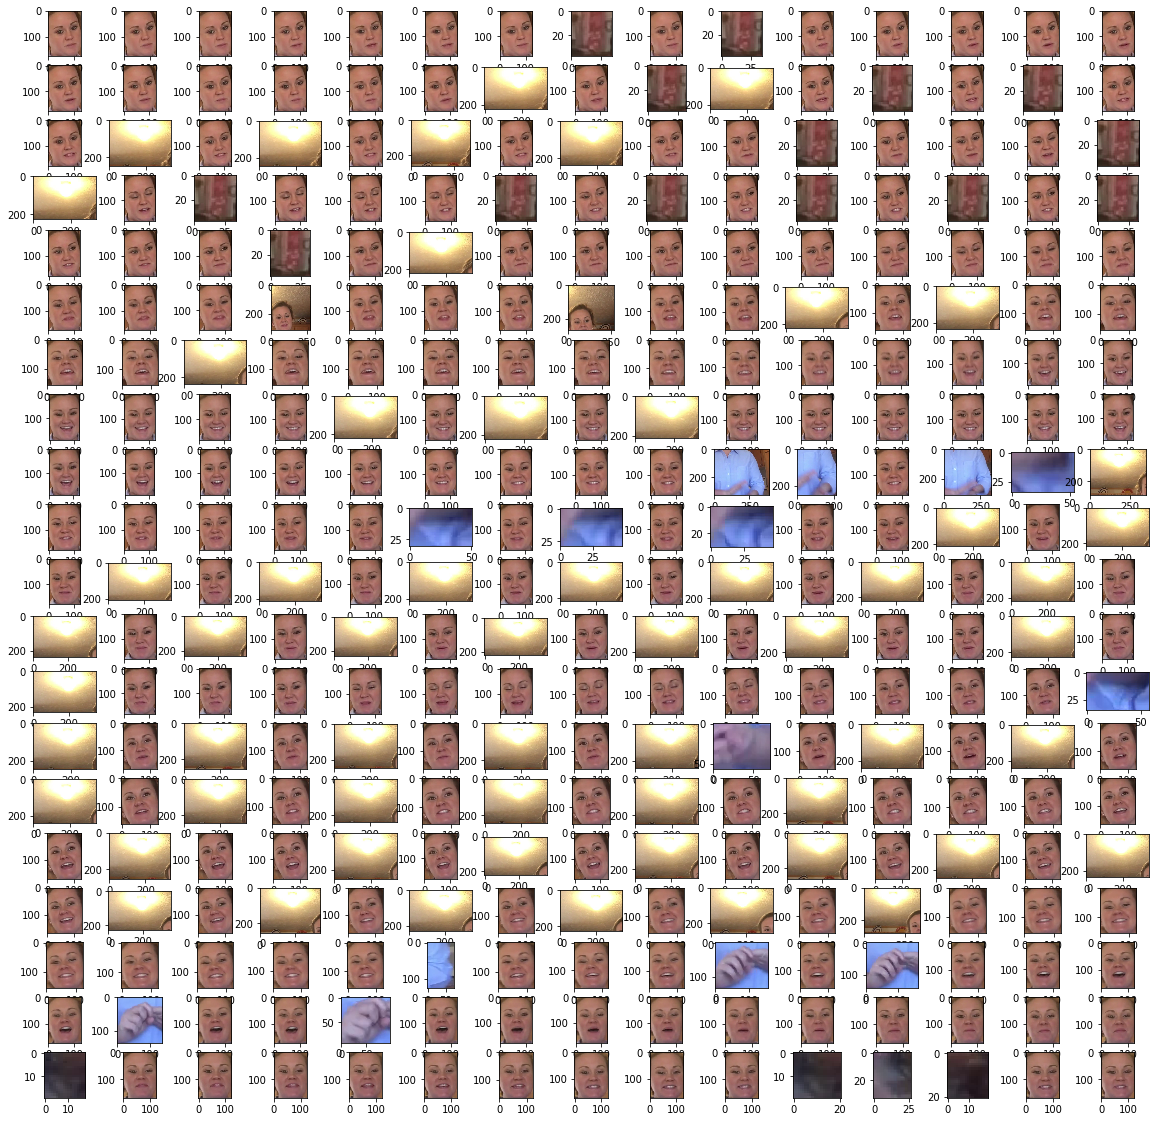

In [25]:
show_faces(all_faces2, 20, 15)

Some takeaways:
 - Faster than Dual Shot Face Detection (about 2x as fast) but slower than the other approaches
 - Seems to have trouble with faces in some frames (detecting background)
 
 
Maybe warrants further investigation of NMS hyper parameters and thresholds? In general doesn't look very good though.